In [11]:
%pylab inline
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.regularizers import l1

import pyprind

Populating the interactive namespace from numpy and matplotlib


# Loading data

In [2]:
data_train = pd.read_csv('UCI HAR Dataset/train/train.csv')
data_test  = pd.read_csv('UCI HAR Dataset/test/test.csv')

In [3]:
X_train = data_train.iloc[:, 1:-6]
Y_train = data_train.iloc[:,-6:]

X_test = data_test.iloc[:, 1:-6]
Y_test = data_test.iloc[:,-6:]

In [4]:
X_train.shape

(7352, 561)

In [5]:
np_X_train = X_train.as_matrix()
np_Y_train = Y_train.as_matrix()

np_X_test = X_test.as_matrix()
np_Y_test = Y_test.as_matrix()

# Creating the model

In [7]:
def create_model(p=None):
    """
    Creates a model based on parameters `p`.

    Example:
    
        p = {'hidden': [64,32], 
             'activation_func': 'tanh', #'relu', 'tanh',
             'l1_reg': 0.01, 
             'optimizer_method': 'SGD'} #'SGD', 'adadelta' 
             
        model = create_model(p)
        
    """
    
    if p==None:
        p = {'hidden': [32],
             'activation_func': 'tanh',
             'l1_reg': 0.01,
             'optimizer_method': 'SGD'}
    hidden = p.get('hidden', [32])
    activation_func = p.get('activation_func', 'tanh')
    l1_reg = p.get('l1_reg', 0.01)
    optimizer_method = p.get('optimizer_method', 'SGD')
    
    model = Sequential()
    model.add(Dense(hidden[0], 
                    input_dim=561, 
                    activation=activation_func, 
                    W_regularizer=l1(l1_reg)))
    hidden = hidden[1:]
    for h in hidden:
        model.add(Dense(h, activation=activation_func, W_regularizer=l1(l1_reg)))
    
    model.add(Dense(6, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer_method, metrics=['accuracy'])
    
    return model

# Training

### Cross-validation

In [8]:
def cross_validation(X,Y, k=10, nn_p=None, verboise=True):
    """
    Runs a k-folded cross validation over a training set. Returns the classification error obtained.
    
    Example:    
    
        error = cross_validation(np_X_train, np_Y_train)
        
    """
    
    if nn_p==None:
        nn_p = {'hidden': [32], 
                'activation_func': 'tanh', #'relu', 'tanh',
                'l1_reg': 0.01, 
                'optimizer_method': 'SGD', #'SGD', 'adadelta'
                'epochs': 10} #Not used in this example, but in cross-validation.
    hidden = nn_p.get('hidden', [32])
    activation_func = nn_p.get('activation_func', 'tanh')
    l1_reg = nn_p.get('l1_reg', 0.01)
    optimizer_method = nn_p.get('optimizer_method', 'SGD')
    epochs = nn_p.get('epochs', 10)

    groups = np.random.choice(X.shape[0],X.shape[0], replace=False) % k
    
    classification_error = []    
    if verboise: 
        print("{}-folded cross-validation:".format(k))
        bar = pyprind.ProgBar(k)
    
    for i in xrange(k):
        i_train = groups!=i
        i_test = groups==i    
        
        model = create_model(nn_p)
        training_results = model.fit(X[i_train,:], Y[i_train,:], 
                                     validation_data=(X[i_test,:],Y[i_test,:]),
                                     nb_epoch=epochs,
                                     verbose=0)
        classification_error.append(1 - training_results.history['val_acc'][-1])
        if verboise: bar.update()
          
    classification_error = mean(classification_error)
    if verboise: print("{}-folded cross-validation classification error: {}".format(k, classification_error))
    
    return classification_error

### Grid search

In [9]:
def grid_search(data, 
                hiddens=None, l1_regs=None, activation_func=None, optimizer_method=None, epochs=None, 
                cv_groups=10):
    """
    Runs a grid search using cross-validation over the hyper-parameters passed. Returns 
    classification error for each configuration.
    
    Example:
        
        hiddens = [[10], [32]]
        l1_regs = [1, 0]
        grid_search_results = grid_search((np_X_train, np_Y_train), 
                                          hiddens=hiddens, l1_regs=l1_regs, 
                                          cv_groups=2)

    """
    if hiddens==None: hiddens=[32]
    if l1_regs==None: l1_regs=[0.01]
    if activation_func==None: activation_func=['tanh']
    if optimizer_method==None: optimizer_method=['SGD']
    if epochs==None: epochs=[10]
    
    grid = [{'hidden':a, 
             'l1_reg':b, 
             'activation_func':c, 
             'optimizer_method':d, 
             'epochs':e}
            for a in hiddens 
            for b in l1_regs
            for c in activation_func
            for d in optimizer_method
            for e in epochs]
    
    bar = pyprind.ProgBar(len(grid))    
    for p in grid:
        p['classification_error'] = cross_validation(data[0], data[1], nn_p=p, k=cv_groups, verboise=False)
        bar.update()
    
    return grid

In [12]:
# Hacemos una grid search
hiddens = [[64,32], [32,10], [10,5], [64], [32], [10]]
l1_regs = [1, 1e-1, 1e-2, 1e-3, 1e-4, 0]
activation_func = ['tanh']
optimizer_method = ['SGD', 'adadelta']
epochs = [10]

grid_search_results = grid_search((np_X_train, np_Y_train), 
                                  hiddens=hiddens, 
                                  l1_regs=l1_regs,
                                  activation_func=activation_func,
                                  optimizer_method=optimizer_method,
                                  epochs=epochs,
                                  cv_groups=2)
print(grid_search_results)

# Elegimos el mejor modelo
best_params = {}
for m in grid_search_results:
    if m['classification_error'] < best_params.get('classification_error', np.inf):
        best_params = m
print(best_params)

0%                          100%
[##############################] | ETA: 00:00:00

[{'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'SGD', 'l1_reg': 1, 'hidden': [64, 32], 'classification_error': 0.80862350380848746}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'adadelta', 'l1_reg': 1, 'hidden': [64, 32], 'classification_error': 0.81719260065288357}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'SGD', 'l1_reg': 0.1, 'hidden': [64, 32], 'classification_error': 0.80862350380848746}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'adadelta', 'l1_reg': 0.1, 'hidden': [64, 32], 'classification_error': 0.80862350380848746}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'SGD', 'l1_reg': 0.01, 'hidden': [64, 32], 'classification_error': 0.13506528822719338}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'adadelta', 'l1_reg': 0.01, 'hidden': [64, 32], 'classification_error': 0.10922198044592196}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'SGD', 'l1_reg': 0.001, 


Total time elapsed: 00:43:51


In [13]:
d = [{'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'SGD', 'hidden': [64, 32], 'l2_reg': 1, 'classification_error': 0.63152883567880758}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'adadelta', 'hidden': [64, 32], 'l2_reg': 1, 'classification_error': 0.60663764960293665}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'SGD', 'hidden': [64, 32], 'l2_reg': 0.1, 'classification_error': 0.14893906413535946}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'adadelta', 'hidden': [64, 32], 'l2_reg': 0.1, 'classification_error': 0.15505984766050057}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'SGD', 'hidden': [64, 32], 'l2_reg': 0.01, 'classification_error': 0.079978237214363479}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'adadelta', 'hidden': [64, 32], 'l2_reg': 0.01, 'classification_error': 0.082018498367791071}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'SGD', 'hidden': [64, 32], 'l2_reg': 0.001, 'classification_error': 0.07712187159956474}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'adadelta', 'hidden': [64, 32], 'l2_reg': 0.001, 'classification_error': 0.036180631120783457}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'SGD', 'hidden': [64, 32], 'l2_reg': 0.0001, 'classification_error': 0.081882480957562565}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'adadelta', 'hidden': [64, 32], 'l2_reg': 0.0001, 'classification_error': 0.050734494015234}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'SGD', 'hidden': [64, 32], 'l2_reg': 0, 'classification_error': 0.072361262241566915}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'adadelta', 'hidden': [64, 32], 'l2_reg': 0, 'classification_error': 0.05318280739934711}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'SGD', 'hidden': [32, 10], 'l2_reg': 1, 'classification_error': 0.63261697496468927}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'adadelta', 'hidden': [32, 10], 'l2_reg': 1, 'classification_error': 0.64077801958650704}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'SGD', 'hidden': [32, 10], 'l2_reg': 0.1, 'classification_error': 0.17668661582197537}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'adadelta', 'hidden': [32, 10], 'l2_reg': 0.1, 'classification_error': 0.14553862894450487}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'SGD', 'hidden': [32, 10], 'l2_reg': 0.01, 'classification_error': 0.09153971708378672}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'adadelta', 'hidden': [32, 10], 'l2_reg': 0.01, 'classification_error': 0.069912948857453749}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'SGD', 'hidden': [32, 10], 'l2_reg': 0.001, 'classification_error': 0.082018498367791071}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'adadelta', 'hidden': [32, 10], 'l2_reg': 0.001, 'classification_error': 0.042845484221980368}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'SGD', 'hidden': [32, 10], 'l2_reg': 0.0001, 'classification_error': 0.079026115342763881}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'adadelta', 'hidden': [32, 10], 'l2_reg': 0.0001, 'classification_error': 0.051822633297062048}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'SGD', 'hidden': [32, 10], 'l2_reg': 0, 'classification_error': 0.088819368879216543}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'adadelta', 'hidden': [32, 10], 'l2_reg': 0, 'classification_error': 0.038084874863982598}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'SGD', 'hidden': [10, 5], 'l2_reg': 1, 'classification_error': 0.81270402611534276}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'adadelta', 'hidden': [10, 5], 'l2_reg': 1, 'classification_error': 0.60908596301947893}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'SGD', 'hidden': [10, 5], 'l2_reg': 0.1, 'classification_error': 0.33569096847638991}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'adadelta', 'hidden': [10, 5], 'l2_reg': 0.1, 'classification_error': 0.26686615896562238}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'SGD', 'hidden': [10, 5], 'l2_reg': 0.01, 'classification_error': 0.10963003264417848}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'adadelta', 'hidden': [10, 5], 'l2_reg': 0.01, 'classification_error': 0.07181719260065289}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'SGD', 'hidden': [10, 5], 'l2_reg': 0.001, 'classification_error': 0.087051142643533141}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'adadelta', 'hidden': [10, 5], 'l2_reg': 0.001, 'classification_error': 0.18743199139217298}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'SGD', 'hidden': [10, 5], 'l2_reg': 0.0001, 'classification_error': 0.18348748639825896}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'adadelta', 'hidden': [10, 5], 'l2_reg': 0.0001, 'classification_error': 0.067872687704026102}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'SGD', 'hidden': [10, 5], 'l2_reg': 0, 'classification_error': 0.17274211092534858}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'adadelta', 'hidden': [10, 5], 'l2_reg': 0, 'classification_error': 0.070865070729053348}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'SGD', 'hidden': [64], 'l2_reg': 1, 'classification_error': 0.30726332980348958}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'adadelta', 'hidden': [64], 'l2_reg': 1, 'classification_error': 0.30073449395037583}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'SGD', 'hidden': [64], 'l2_reg': 0.1, 'classification_error': 0.093307943416757355}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'adadelta', 'hidden': [64], 'l2_reg': 0.1, 'classification_error': 0.12064744287268769}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'SGD', 'hidden': [64], 'l2_reg': 0.01, 'classification_error': 0.08133841131664854}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'adadelta', 'hidden': [64], 'l2_reg': 0.01, 'classification_error': 0.048014145810663766}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'SGD', 'hidden': [64], 'l2_reg': 0.001, 'classification_error': 0.093579978237214367}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'adadelta', 'hidden': [64], 'l2_reg': 0.001, 'classification_error': 0.038492927094668117}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'SGD', 'hidden': [64], 'l2_reg': 0.0001, 'classification_error': 0.10881392818280738}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'adadelta', 'hidden': [64], 'l2_reg': 0.0001, 'classification_error': 0.038900979325353635}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'SGD', 'hidden': [64], 'l2_reg': 0, 'classification_error': 0.082290533188248083}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'adadelta', 'hidden': [64], 'l2_reg': 0, 'classification_error': 0.037268770402611506}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'SGD', 'hidden': [32], 'l2_reg': 1, 'classification_error': 0.25462459198019838}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'adadelta', 'hidden': [32], 'l2_reg': 1, 'classification_error': 0.26128944498410811}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'SGD', 'hidden': [32], 'l2_reg': 0.1, 'classification_error': 0.093579978237214367}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'adadelta', 'hidden': [32], 'l2_reg': 0.1, 'classification_error': 0.10187704019629529}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'SGD', 'hidden': [32], 'l2_reg': 0.01, 'classification_error': 0.085554951033732285}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'adadelta', 'hidden': [32], 'l2_reg': 0.01, 'classification_error': 0.051278563656147969}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'SGD', 'hidden': [32], 'l2_reg': 0.001, 'classification_error': 0.081066376496191528}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'adadelta', 'hidden': [32], 'l2_reg': 0.001, 'classification_error': 0.045021762785636577}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'SGD', 'hidden': [32], 'l2_reg': 0.0001, 'classification_error': 0.084466811751904236}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'adadelta', 'hidden': [32], 'l2_reg': 0.0001, 'classification_error': 0.04434167573449399}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'SGD', 'hidden': [32], 'l2_reg': 0, 'classification_error': 0.085282916213275328}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'adadelta', 'hidden': [32], 'l2_reg': 0, 'classification_error': 0.044341675734494046}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'SGD', 'hidden': [10], 'l2_reg': 1, 'classification_error': 0.26060935815996911}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'adadelta', 'hidden': [10], 'l2_reg': 1, 'classification_error': 0.20443416747616217}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'SGD', 'hidden': [10], 'l2_reg': 0.1, 'classification_error': 0.11071817192600653}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'adadelta', 'hidden': [10], 'l2_reg': 0.1, 'classification_error': 0.099020674646354723}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'SGD', 'hidden': [10], 'l2_reg': 0.01, 'classification_error': 0.10214907508161042}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'adadelta', 'hidden': [10], 'l2_reg': 0.01, 'classification_error': 0.06338411316648529}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'SGD', 'hidden': [10], 'l2_reg': 0.001, 'classification_error': 0.10133297062023938}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'adadelta', 'hidden': [10], 'l2_reg': 0.001, 'classification_error': 0.059983677910772581}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'SGD', 'hidden': [10], 'l2_reg': 0.0001, 'classification_error': 0.092899891186071837}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'adadelta', 'hidden': [10], 'l2_reg': 0.0001, 'classification_error': 0.065968443960826961}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'SGD', 'hidden': [10], 'l2_reg': 0, 'classification_error': 0.10500544069640916}, {'activation_func': 'tanh', 'epochs': 10, 'optimizer_method': 'adadelta', 'hidden': [10], 'l2_reg': 0, 'classification_error': 0.059575625680087063}]

### Entrenamiento del modelo final

In [14]:
model = create_model(best_params)
training_results = model.fit(np_X_train, np_Y_train, 
                             validation_data=(np_X_test, np_Y_test),
                             nb_epoch=10)

Train on 7352 samples, validate on 2947 samples
Epoch 1/10
7352/7352 [==============================] - 3s - loss: 0.8128 - acc: 0.8104 - val_loss: 0.3914 - val_acc: 0.8935
Epoch 2/10
7352/7352 [==============================] - 2s - loss: 0.4567 - acc: 0.9144 - val_loss: 0.2308 - val_acc: 0.9321
Epoch 3/10
7352/7352 [==============================] - 2s - loss: 0.3675 - acc: 0.9433 - val_loss: 0.2580 - val_acc: 0.8935
Epoch 4/10
7352/7352 [==============================] - 2s - loss: 0.3203 - acc: 0.9546 - val_loss: 0.1705 - val_acc: 0.9382
Epoch 5/10
7352/7352 [==============================] - 2s - loss: 0.2970 - acc: 0.9601 - val_loss: 0.2073 - val_acc: 0.9206
Epoch 6/10
7352/7352 [==============================] - 2s - loss: 0.2773 - acc: 0.9642 - val_loss: 0.2663 - val_acc: 0.8839
Epoch 7/10
7352/7352 [==============================] - 2s - loss: 0.2612 - acc: 0.9701 - val_loss: 0.1400 - val_acc: 0.9450
Epoch 8/10
7352/7352 [==============================] - 2s - loss: 0.2495 - a

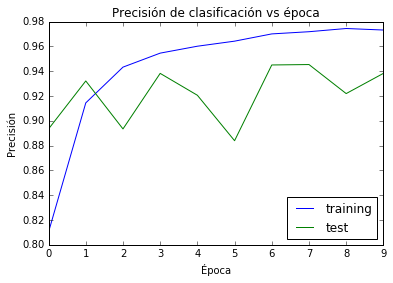

In [15]:
pylab.plot(training_results.epoch, training_results.history['acc'], label='training')
pylab.plot(training_results.epoch, training_results.history['val_acc'], label='test')
pylab.legend(loc='lower right')
pylab.xlabel(u"Época")
pylab.ylabel(u"Precisión")
pylab.title(u"Precisión de clasificación vs época")

# Evaluating models

In [37]:
error = 1 - model.evaluate(np_X_train, np_Y_train)[1]
print("\nE_in = {}".format(error))

7328/7352 [============================>.] - ETA: 0s
E_in = 0.0214907508161


In [38]:
error = 1 - model.evaluate(np_X_test, np_Y_test)[1]
print("\nE_test = {}".format(error))

2912/2947 [============================>.] - ETA: 0s
E_test = 0.061757719715


In [41]:
from sklearn.metrics import confusion_matrix
classes = model.predict_classes(np_X_test)
print "\nMatriz de confusión:"
print confusion_matrix(np.argmax(np_Y_test,axis=1), classes).tolist()

2912/2947 [============================>.] - ETA: 0s
Matriz de confusión:
[[526, 0, 11, 0, 0, 0], [0, 393, 96, 0, 0, 2], [0, 14, 518, 0, 0, 0], [0, 0, 0, 482, 9, 5], [0, 0, 0, 4, 392, 24], [0, 0, 1, 14, 2, 454]]
